# Demo of SCOD on MNIST

In [36]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, KMNIST, EMNIST
from torch.utils.data import Subset
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
mnist = MNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
dataset = Subset(mnist, np.random.choice(len(mnist), 5000))

In [40]:
val_dataset =  MNIST(root="~/data/",train=False,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
fashion_dataset = FashionMNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
kmnist_dataset = KMNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
emnist_dataset = EMNIST(root="~/data/",train=True,split="letters",download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))

In [5]:
# DNN mapping 2d input to 1d distribution parameter
# LeNet v5
model = nn.Sequential(
        nn.Conv2d(1, 6, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Conv2d(6, 16, 5, 1),
        nn.ReLU(),
        nn.AvgPool2d(2),
        nn.Flatten(),
        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Categorical(logits=theta)

In [11]:
device=torch.device('cuda:0')
model = model.to(device)

mean_loss=0.002955,lr=0.000000: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


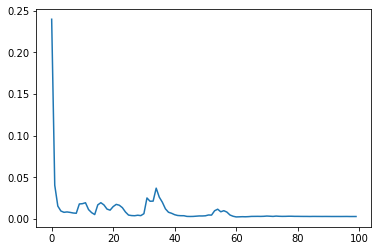

In [13]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

losses = []
t = trange(100)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs.to(device))
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets.to(device))

        mean_loss = loss.mean()

        regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / 2e3

        total_loss = mean_loss + regularization

        total_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
    scheduler.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f,lr=%02f"%(epoch_loss.item(),scheduler.get_last_lr()[0]))
    losses.append(epoch_loss.item())

plt.plot(losses)

In [14]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

<class 'scod.sketching.sketched_pca.SRFT_SinglePassPCA'>


### process training dataset to compute posterior uncertainty

In [15]:
unc_model.process_dataset(dataset)

  0%|          | 10/5000 [00:00<00:50, 98.49it/s]

computing basis
using T = 304


100%|██████████| 5000/5000 [00:46<00:00, 106.88it/s]


### use validation dataset to optimize prior variance

In [23]:
unc_model.optimize_prior_scale_by_nll(Subset(val_dataset, np.random.choice(len(val_dataset), 500)),
                                      num_epochs=10, max_ent_weight=1.)

100%|██████████| 10/10 [00:38<00:00,  3.82s/it, eps=0.132]


### compare SCOD's predictions to the original trained model

In [41]:
from torch.utils.data import DataLoader
from tqdm import tqdm
val_subset = Subset(val_dataset, np.random.choice(len(val_dataset), 500))
fashion_subset = Subset(fashion_dataset, np.random.choice(len(fashion_dataset), 500))
kmnist_subset = Subset(kmnist_dataset, np.random.choice(len(kmnist_dataset), 500))
emnist_subset = Subset(emnist_dataset, np.random.choice(len(emnist_dataset), 500))


val_base = torch.cat( [ dist_constructor(model(batch[0].to(device))).entropy() for batch in tqdm(DataLoader(val_subset, batch_size=25, shuffle=False)) ] )
fashion_base = torch.cat( [ dist_constructor(model(batch[0].to(device))).entropy() for batch in tqdm(DataLoader(fashion_subset, batch_size=25, shuffle=False)) ] )
kmnist_base = torch.cat( [ dist_constructor(model(batch[0].to(device))).entropy() for batch in tqdm(DataLoader(kmnist_subset, batch_size=25, shuffle=False)) ] )
emnist_base = torch.cat( [ dist_constructor(model(batch[0].to(device))).entropy() for batch in tqdm(DataLoader(emnist_subset, batch_size=25, shuffle=False)) ] )

val_uncs = torch.cat( [ unc_model(batch[0].to(device))[1] for batch in tqdm(DataLoader(val_subset, batch_size=25, shuffle=False)) ] )
fashion_uncs = torch.cat( [ unc_model(batch[0].to(device))[1] for batch in tqdm(DataLoader(fashion_subset, batch_size=25, shuffle=False)) ] )
kmnist_uncs = torch.cat( [ unc_model(batch[0].to(device))[1] for batch in tqdm(DataLoader(kmnist_subset, batch_size=25, shuffle=False)) ] )
emnist_uncs = torch.cat( [ unc_model(batch[0].to(device))[1] for batch in tqdm(DataLoader(emnist_subset, batch_size=25, shuffle=False)) ] )


100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


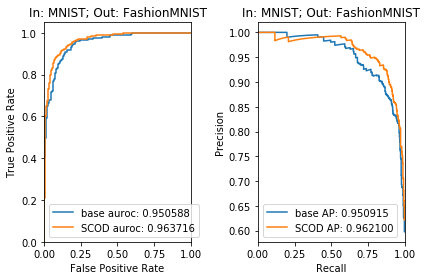

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

groups = [
    ('base', val_base, fashion_base),
    ('SCOD', val_uncs, fashion_uncs),
]

fig, axes = plt.subplots(1,2)

for label, in_uncs, out_uncs in groups:
    y_true = np.concatenate([np.zeros(500), np.ones(500)])
    preds = torch.cat([in_uncs, out_uncs]).detach().cpu()
    fpr, tpr, thresh = roc_curve(y_true, preds)
    auroc = roc_auc_score(y_true, preds)

    precision, recall, _ = precision_recall_curve(y_true, preds)
    avg_prec = average_precision_score(y_true, preds)

    axes[0].plot(fpr, tpr, label=(label + " auroc: %03f" % auroc))
    axes[1].plot(recall, precision, label=(label + " AP: %03f" % avg_prec))

axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].set_title("In: MNIST; Out: FashionMNIST")
axes[1].set_xlim([0.0, 1.0])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()
axes[1].set_title("In: MNIST; Out: FashionMNIST")
plt.tight_layout()
plt.show()

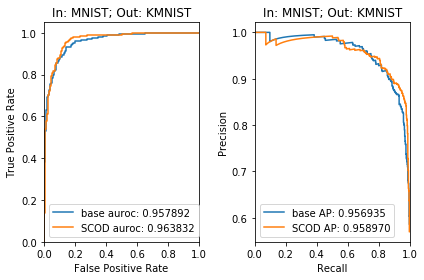

In [34]:
groups = [
    ('base', val_base, kmnist_base),
    ('SCOD', val_uncs, kmnist_uncs),
]

fig, axes = plt.subplots(1,2)

for label, in_uncs, out_uncs in groups:
    y_true = np.concatenate([np.zeros(500), np.ones(500)])
    preds = torch.cat([in_uncs, out_uncs]).detach().cpu()
    fpr, tpr, thresh = roc_curve(y_true, preds)
    auroc = roc_auc_score(y_true, preds)

    precision, recall, _ = precision_recall_curve(y_true, preds)
    avg_prec = average_precision_score(y_true, preds)

    axes[0].plot(fpr, tpr, label=(label + " auroc: %03f" % auroc))
    axes[1].plot(recall, precision, label=(label + " AP: %03f" % avg_prec))

axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].set_title("In: MNIST; Out: KMNIST")
axes[1].set_xlim([0.0, 1.0])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()
axes[1].set_title("In: MNIST; Out: KMNIST")
plt.tight_layout()
plt.show()

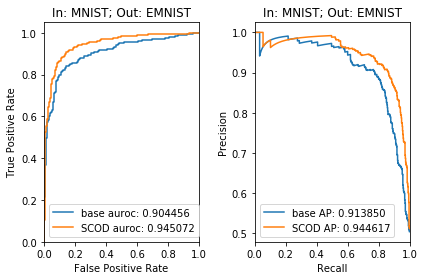

In [42]:
groups = [
    ('base', val_base, emnist_base),
    ('SCOD', val_uncs, emnist_uncs),
]

fig, axes = plt.subplots(1,2)

for label, in_uncs, out_uncs in groups:
    y_true = np.concatenate([np.zeros(500), np.ones(500)])
    preds = torch.cat([in_uncs, out_uncs]).detach().cpu()
    fpr, tpr, thresh = roc_curve(y_true, preds)
    auroc = roc_auc_score(y_true, preds)

    precision, recall, _ = precision_recall_curve(y_true, preds)
    avg_prec = average_precision_score(y_true, preds)

    axes[0].plot(fpr, tpr, label=(label + " auroc: %03f" % auroc))
    axes[1].plot(recall, precision, label=(label + " AP: %03f" % avg_prec))

axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].set_title("In: MNIST; Out: EMNIST")
axes[1].set_xlim([0.0, 1.0])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()
axes[1].set_title("In: MNIST; Out: EMNIST")
plt.tight_layout()
plt.show()